In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

In [3]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

# Real-World Application to US Data

### Setup

Load US state case data from the NYT archive

In [4]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()
states

state    date      
Alabama  2020-03-13      6
         2020-03-14     12
         2020-03-15     23
         2020-03-16     29
         2020-03-17     39
                      ... 
Wyoming  2020-04-16    296
         2020-04-17    305
         2020-04-18    309
         2020-04-19    313
         2020-04-20    317
Name: cases, Length: 2721, dtype: int64

In [5]:
states.index

MultiIndex([('Alabama', '2020-03-13'),
            ('Alabama', '2020-03-14'),
            ('Alabama', '2020-03-15'),
            ('Alabama', '2020-03-16'),
            ('Alabama', '2020-03-17'),
            ('Alabama', '2020-03-18'),
            ('Alabama', '2020-03-19'),
            ('Alabama', '2020-03-20'),
            ('Alabama', '2020-03-21'),
            ('Alabama', '2020-03-22'),
            ...
            ('Wyoming', '2020-04-11'),
            ('Wyoming', '2020-04-12'),
            ('Wyoming', '2020-04-13'),
            ('Wyoming', '2020-04-14'),
            ('Wyoming', '2020-04-15'),
            ('Wyoming', '2020-04-16'),
            ('Wyoming', '2020-04-17'),
            ('Wyoming', '2020-04-18'),
            ('Wyoming', '2020-04-19'),
            ('Wyoming', '2020-04-20')],
           names=['state', 'date'], length=2721)

# Finland Data

In [6]:
# TODO: get data straight from THL?

#finland = pd.read_csv('finland_stat.csv', sep='\t', 
#                      skiprows=1, header=None, names = ['date', 'cases_in_day'],
#                      parse_dates=['date'])
#finland.columns = ['date', 'cases_in_day']

import requests

url = "https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/processedThlData"

payload = ""
response = requests.request("GET", url, data=payload)

c = response.json()

finland = pd.DataFrame(c['confirmed']['Kaikki sairaanhoitopiirit'])
finland['date'] = finland['date'].apply(pd.to_datetime).dt.date
finland.set_index(finland['date'], inplace=True)

finland = finland[:-5]

finland

,value,healthCareDistrict,date
date,,,
2020-01-01,0,Kaikki sairaanhoitopiirit,2020-01-01
2020-01-02,0,Kaikki sairaanhoitopiirit,2020-01-02
2020-01-03,0,Kaikki sairaanhoitopiirit,2020-01-03
2020-01-04,0,Kaikki sairaanhoitopiirit,2020-01-04
2020-01-05,0,Kaikki sairaanhoitopiirit,2020-01-05
...,...,...,...
2020-04-13,105,Kaikki sairaanhoitopiirit,2020-04-13
2020-04-14,149,Kaikki sairaanhoitopiirit,2020-04-14
2020-04-15,118,Kaikki sairaanhoitopiirit,2020-04-15


In [7]:
finland['cases']

KeyError: 'cases'

In [8]:
finland['date'].apply(type)

date
2020-01-01    <class 'datetime.date'>
2020-01-02    <class 'datetime.date'>
2020-01-03    <class 'datetime.date'>
2020-01-04    <class 'datetime.date'>
2020-01-05    <class 'datetime.date'>
                       ...           
2020-04-13    <class 'datetime.date'>
2020-04-14    <class 'datetime.date'>
2020-04-15    <class 'datetime.date'>
2020-04-16    <class 'datetime.date'>
2020-04-17    <class 'datetime.date'>
Name: date, Length: 108, dtype: object

In [9]:
state_name = 'Finland'
finland['cases'].rename(f"{state_name} cases")

KeyError: 'cases'

In [53]:
#finland['cases_in_day']

In [54]:
#finland['cases'].diff()

In [55]:
cases = finland['cases'].rename(f"{state_name} cases")
type(cases)

pandas.core.series.Series

In [56]:
type(cases.diff())

pandas.core.series.Series

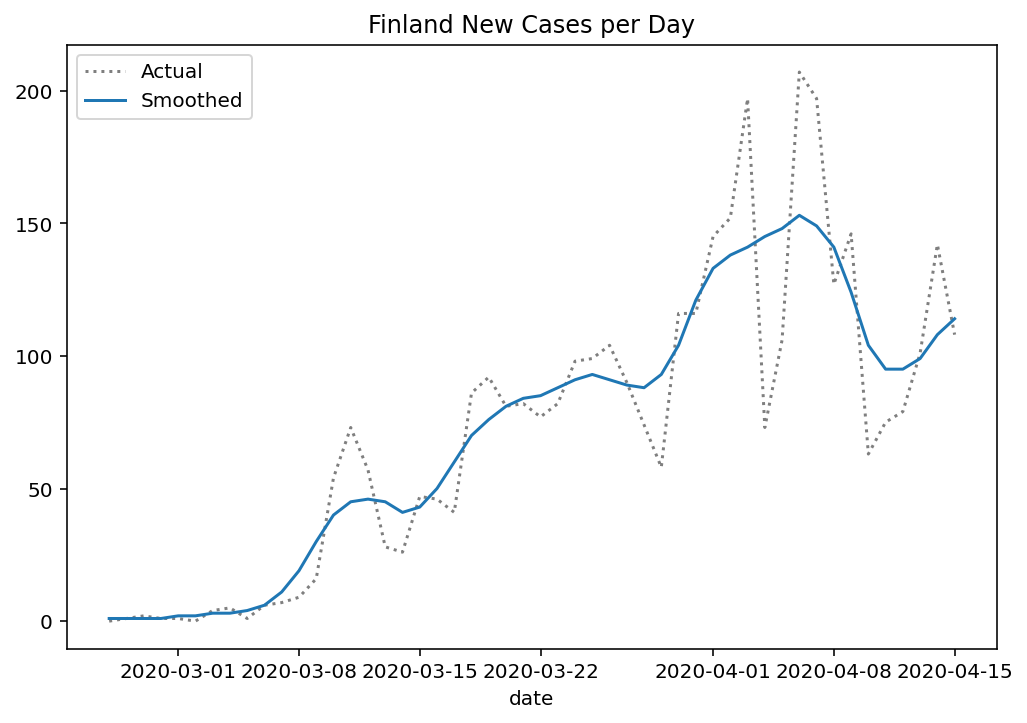

In [65]:
#state_name = 'New York'
state_name = 'Finland'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

#cases = states.xs(state_name).rename(f"{state_name} cases")
cases = finland['cases'].rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases[:-5])

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [58]:
original

date
2020-02-26      0.0
2020-02-27      1.0
2020-02-28      2.0
2020-02-29      1.0
2020-03-01      1.0
2020-03-02      0.0
2020-03-03      4.0
2020-03-04      5.0
2020-03-05      1.0
2020-03-06      6.0
2020-03-07      7.0
2020-03-08      9.0
2020-03-09     16.0
2020-03-10     54.0
2020-03-11     73.0
2020-03-12     57.0
2020-03-13     28.0
2020-03-14     26.0
2020-03-15     47.0
2020-03-16     46.0
2020-03-17     41.0
2020-03-18     86.0
2020-03-19     92.0
2020-03-20     81.0
2020-03-21     82.0
2020-03-22     77.0
2020-03-23     82.0
2020-03-24     98.0
2020-03-25     99.0
2020-03-26    104.0
2020-03-27     90.0
2020-03-28     74.0
2020-03-29     58.0
2020-03-30    116.0
2020-03-31    116.0
2020-04-01    145.0
2020-04-02    152.0
2020-04-03    197.0
2020-04-04     73.0
2020-04-05    106.0
2020-04-06    207.0
2020-04-07    197.0
2020-04-08    127.0
2020-04-09    146.0
2020-04-10     63.0
2020-04-11     75.0
2020-04-12     79.0
2020-04-13    101.0
2020-04-14    142.0
2020-04-15    1

In [59]:
smoothed

date
2020-02-26      1.0
2020-02-27      1.0
2020-02-28      1.0
2020-02-29      1.0
2020-03-01      2.0
2020-03-02      2.0
2020-03-03      3.0
2020-03-04      3.0
2020-03-05      4.0
2020-03-06      6.0
2020-03-07     11.0
2020-03-08     19.0
2020-03-09     30.0
2020-03-10     40.0
2020-03-11     45.0
2020-03-12     46.0
2020-03-13     45.0
2020-03-14     41.0
2020-03-15     43.0
2020-03-16     50.0
2020-03-17     60.0
2020-03-18     70.0
2020-03-19     76.0
2020-03-20     81.0
2020-03-21     84.0
2020-03-22     85.0
2020-03-23     88.0
2020-03-24     91.0
2020-03-25     93.0
2020-03-26     91.0
2020-03-27     89.0
2020-03-28     88.0
2020-03-29     93.0
2020-03-30    104.0
2020-03-31    121.0
2020-04-01    133.0
2020-04-02    138.0
2020-04-03    141.0
2020-04-04    145.0
2020-04-05    148.0
2020-04-06    153.0
2020-04-07    149.0
2020-04-08    141.0
2020-04-09    124.0
2020-04-10    104.0
2020-04-11     95.0
2020-04-12     95.0
2020-04-13     99.0
2020-04-14    106.0
2020-04-15    1

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [60]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

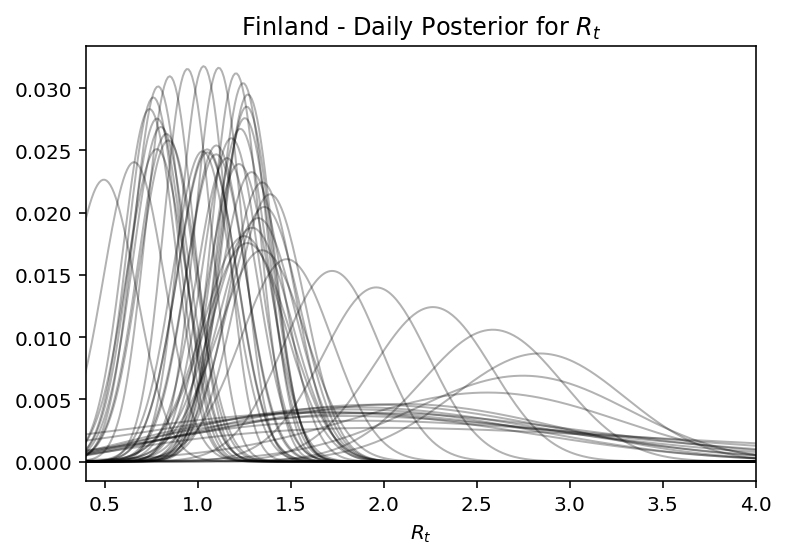

In [61]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [90]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-04-16,0.83,0.54,1.14
2020-04-17,0.84,0.54,1.15
2020-04-18,0.78,0.47,1.10
2020-04-19,0.66,0.34,1.00
2020-04-20,0.50,0.16,0.85


In [93]:
result[:-10]

,ML,Low,High
date,,,
2020-02-26,2.00,0.34,6.43
2020-02-27,1.88,0.38,5.01
2020-02-28,1.80,0.38,4.45
2020-02-29,1.74,0.40,4.13
2020-03-01,1.96,0.50,4.24
2020-03-02,1.83,0.46,3.79
2020-03-03,1.94,0.55,3.75
2020-03-04,1.67,0.01,3.35
2020-03-05,1.83,0.11,3.44


In [94]:
result.head()

,ML,Low,High
date,,,
2020-02-26,2.00,0.34,6.43
2020-02-27,1.88,0.38,5.01
2020-02-28,1.80,0.38,4.45
2020-02-29,1.74,0.40,4.13
2020-03-01,1.96,0.50,4.24


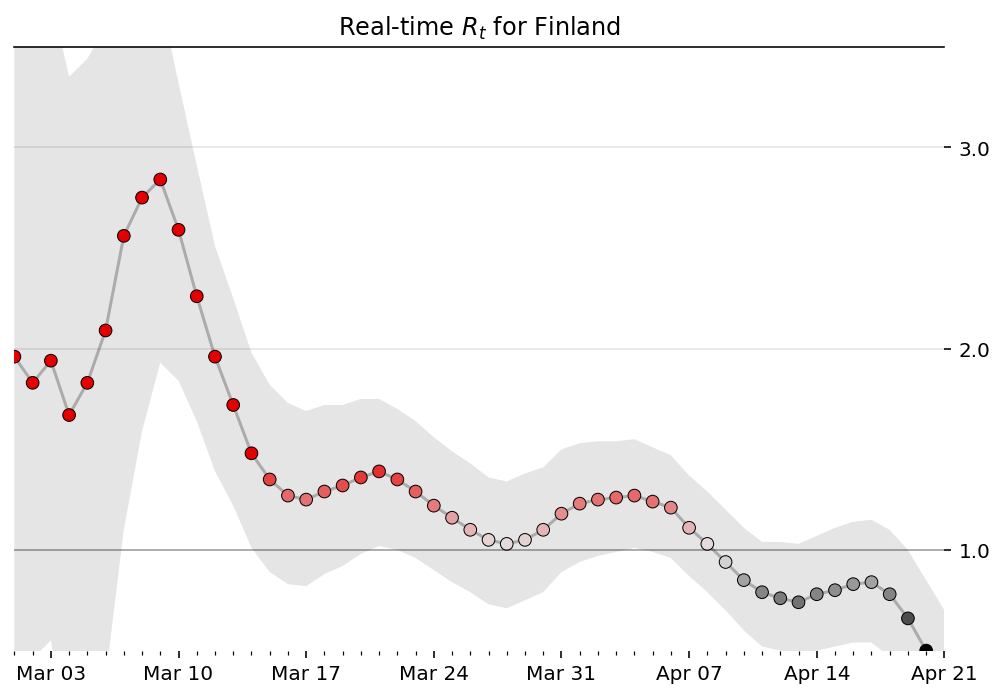

In [63]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [79]:
import requests

url = "https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/processedThlData"

payload = ""
response = requests.request("GET", url, data=payload)

c = response.json()
c

{'confirmed': {'Ahvenanmaa': [{'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-01T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-02T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-03T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-04T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-05T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-06T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-07T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-08T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-09T15:00:00.000Z'},
   {'value': 0,
    'healthCareDistrict': 'Ahvenanmaa',
    'date': '2020-01-10T15:00:00.000Z'},
   

In [85]:
response.status_code

200

In [21]:
c['confirmed']['Kaikki sairaanhoitopiirit']

[{'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-01T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-02T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-03T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-04T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-05T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-06T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-07T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-08T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki sairaanhoitopiirit',
  'date': '2020-01-09T15:00:00.000Z'},
 {'value': 0,
  'healthCareDistrict': 'Kaikki 

In [78]:
c.keys()

dict_keys(['confirmed'])

In [22]:
c_df = pd.DataFrame(c['confirmed']['Kaikki sairaanhoitopiirit'])
c_df['date'] = c_df['date'].apply(pd.to_datetime).dt.date
c_df.set_index(c_df['date'], inplace=True)
c_df

,value,healthCareDistrict,date
date,,,
2020-01-01,0,Kaikki sairaanhoitopiirit,2020-01-01
2020-01-02,0,Kaikki sairaanhoitopiirit,2020-01-02
2020-01-03,0,Kaikki sairaanhoitopiirit,2020-01-03
2020-01-04,0,Kaikki sairaanhoitopiirit,2020-01-04
2020-01-05,0,Kaikki sairaanhoitopiirit,2020-01-05
...,...,...,...
2020-04-16,90,Kaikki sairaanhoitopiirit,2020-04-16
2020-04-17,108,Kaikki sairaanhoitopiirit,2020-04-17
2020-04-18,49,Kaikki sairaanhoitopiirit,2020-04-18


In [23]:
c_df['value'][-20:]

date
2020-04-01    145
2020-04-02    152
2020-04-03    197
2020-04-04     73
2020-04-05    106
2020-04-06    207
2020-04-07    197
2020-04-08    127
2020-04-09    146
2020-04-10     63
2020-04-11     75
2020-04-12     79
2020-04-13    101
2020-04-14    142
2020-04-15    108
2020-04-16     90
2020-04-17    108
2020-04-18     49
2020-04-19     21
2020-04-20      0
Name: value, dtype: int64

In [70]:
from datetime import datetime as dt
from datetime import timedelta

In [73]:
dt.today().date()

datetime.date(2020, 4, 20)

In [74]:
last_day = dt.today().date() - timedelta(5)
last_day

datetime.date(2020, 4, 15)

In [77]:
finland[finland['date'] < last_day]

,value,healthCareDistrict,date,cases
date,,,,
2020-01-01,0,Kaikki sairaanhoitopiirit,2020-01-01,0
2020-01-02,0,Kaikki sairaanhoitopiirit,2020-01-02,0
2020-01-03,0,Kaikki sairaanhoitopiirit,2020-01-03,0
2020-01-04,0,Kaikki sairaanhoitopiirit,2020-01-04,0
2020-01-05,0,Kaikki sairaanhoitopiirit,2020-01-05,0
...,...,...,...,...
2020-04-10,63,Kaikki sairaanhoitopiirit,2020-04-10,3095
2020-04-11,75,Kaikki sairaanhoitopiirit,2020-04-11,3170
2020-04-12,79,Kaikki sairaanhoitopiirit,2020-04-12,3249


In [ ]:
# finland.set_index(finland['date'], inplace=True)